In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import random

# Additional imports for variational layers
from data_handler import *
from trainer import *
from uncertainty import *
from linear_variational import *

def set_random_seed(seed_value=42):
    # Python random seed
    random.seed(seed_value)
    
    # Numpy random seed
    np.random.seed(seed_value)
    
    # PyTorch seed
    torch.manual_seed(seed_value)
    
    # If using CUDA (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
        torch.backends.cudnn.deterministic = True  # For reproducibility
        torch.backends.cudnn.benchmark = False  # Disable auto-optimization for determinism

set_random_seed()

In [2]:
data = pd.read_csv('./microreactor_preprocessed.csv', header="infer")
data

,Unnamed: 0,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,fluxQ1,fluxQ2,fluxQ3,fluxQ4
0,sample_00000,2.237507,-1.698166,2.433453,1.253772,3.140399,-3.082829,2.754851,0.386800,0.248175,0.249199,0.256734,0.245892
1,sample_00000_h,1.253772,2.433453,-1.698166,2.237507,0.386800,2.754851,-3.082829,3.140399,0.249199,0.248175,0.245892,0.256734
2,sample_00000_r,-3.140399,3.082829,-2.754851,-0.386800,-2.237507,1.698166,-2.433453,-1.253772,0.256734,0.245892,0.248175,0.249199
3,sample_00000_v,-0.386800,-2.754851,3.082829,-3.140399,-1.253772,-2.433453,1.698166,-2.237507,0.245892,0.256734,0.249199,0.248175
4,sample_00001,-1.519638,2.489141,-1.853817,1.147173,-2.058398,0.755909,-0.091469,2.379043,0.252723,0.250798,0.248167,0.248312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,sample_00817_v,-1.247326,-3.099257,2.267060,-1.909570,-0.263247,-0.705058,2.873758,2.332428,0.251804,0.250008,0.243343,0.254845
3000,sample_00818,-0.075964,1.403187,-2.678154,-0.037988,-1.921514,2.134915,0.195766,3.045334,0.245477,0.249179,0.255498,0.249846
3001,sample_00818_h,-0.037988,-2.678154,1.403187,-0.075964,3.045334,0.195766,2.134915,-1.921514,0.249179,0.245477,0.249846,0.255498
3002,sample_00818_r,1.921514,-2.134915,-0.195766,-3.045334,0.075964,-1.403187,2.678154,0.037988,0.255498,0.249846,0.245477,0.249179


## Data Preprocessing
### 1. Split data
### 2. Scale data (MinMax)
### 3. Convert Numpy arrays to PyTorch tensors
### 4. Place PyTorch tensors in TensorDatasets
### 5. Create Dataloaders with input-output TensorDataset pairs

In [12]:
input_slice = slice(1,9)
output_slice = slice(9, 14)

input = data.iloc[:, input_slice]
output = data.iloc[:, output_slice]

def train_val_test_split(X, y, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)  # Calculate the ratio of validation to training size
    
    # Step 1: Split the data into (train+val) and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    
    # Step 2: Split the (train+val) set into actual training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    
    return X_train, X_val, X_test, y_train, y_val, y_test  # Return all six sets

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(input, output, 0.15)

# Scale data
Xscaler = MinMaxScaler()
Yscaler = MinMaxScaler()

X_train_arr = Xscaler.fit_transform(X_train)
X_val_arr = Xscaler.transform(X_val)
X_test_arr = Xscaler.transform(X_test)

y_train_arr = Yscaler.fit_transform(y_train)
y_val_arr = Yscaler.transform(y_val)
y_test_arr = Yscaler.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_arr, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_arr, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_arr, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_arr, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_arr, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_arr, dtype=torch.float32)

# Store as tensor datasets
train = TensorDataset(X_train_tensor, y_train_tensor)
val = TensorDataset(X_val_tensor, y_val_tensor)
test = TensorDataset(X_test_tensor, y_test_tensor)

# Put TensorDatasets in Dataloaders
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

# Print to inspect
print(f"Train Tensors (X, y): {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Validation Tensor (X, y): {X_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test Tensor (X, y): {X_test_tensor.shape}, {y_test_tensor.shape}")
print()

for batch_index, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_index+1}")
    print(f"    Input Shape: {inputs.shape}")
    print(f"    Target Shape: {targets.shape}")
    break

print(X_train)
print(y_train)

Train Tensors (X, y): torch.Size([2102, 8]), torch.Size([2102, 4])
Validation Tensor (X, y): torch.Size([451, 8]), torch.Size([451, 4])
Test Tensor (X, y): torch.Size([451, 8]), torch.Size([451, 4])

Batch 1
    Input Shape: torch.Size([64, 8])
    Target Shape: torch.Size([64, 4])
        theta1    theta2    theta3    theta4    theta5    theta6    theta7  \
0     2.237507 -1.698166  2.433453  1.253772  3.140399 -3.082829  2.754851   
1     1.253772  2.433453 -1.698166  2.237507  0.386800  2.754851 -3.082829   
2    -3.140399  3.082829 -2.754851 -0.386800 -2.237507  1.698166 -2.433453   
3    -0.386800 -2.754851  3.082829 -3.140399 -1.253772 -2.433453  1.698166   
4    -1.519638  2.489141 -1.853817  1.147173 -2.058398  0.755909 -0.091469   
...        ...       ...       ...       ...       ...       ...       ...   
2097  2.918142  1.095613 -1.076405  2.212824 -2.182229 -2.397824 -2.602091   
2098 -0.501279  2.602091  2.397824  2.182229 -2.212824  1.076405 -1.095613   
2099  2.182229 

## Define model architecture

In [13]:
class vFNN(nn.Module):
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features, prior_mean=0, prior_variance=0.5, posterior_rho_init=-4.0, bias=True):
        super(vFNN, self).__init__()

        # Define the first linear layer with reparameterization
        self.input = LinearReparameterization(
            in_features=in_features,
            out_features=hidden_size1,
            prior_mean=prior_mean,
            prior_variance=prior_variance,
            posterior_rho_init=posterior_rho_init,
            bias=bias
        )

        # Define the second linear layer with reparameterization
        self.fc1 = LinearReparameterization(
            in_features=hidden_size1,
            out_features=hidden_size2,
            prior_mean=prior_mean,
            prior_variance=prior_variance,
            posterior_rho_init=posterior_rho_init,
            bias=bias
        )

        # Define the third (final) linear layer with reparameterization
        self.fc2 = LinearReparameterization(
            in_features=hidden_size2,
            out_features=out_features,
            prior_mean=prior_mean,
            prior_variance=prior_variance,
            posterior_rho_init=posterior_rho_init,
            bias=bias
        )

    def forward(self, x):
        # Pass the input through each linear layer with ReLU activation in between
        x, kl1 = self.input(x)
        x = F.relu(x)  # Apply non-linearity

        x, kl2 = self.fc1(x)
        x = F.relu(x)  # Apply non-linearity

        output, kl3 = self.fc2(x)

        # Sum the KL divergences from each layer
        kl_total = kl1 + kl2 + kl3

        # Return the final output and the total KL divergence
        return output, kl_total

## Build training loop

In [17]:
# Training process (with KL divergence handling)
def train_model(model, train_loader, val_loader, num_epochs, reconstruction_loss_fn, optimizer, device=torch.device('cpu'), kl_schedule=None):
    model.to(device)
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()

        if kl_schedule == 'linear':
            kl_weight = 0.05 * (epoch / num_epochs)
        elif kl_schedule == 'sigmoid_growth':
            kl_weight = 0.05 / (1 + np.exp(-2 * (epoch - 0.7 * num_epochs))) + 0.005 # max / (1 + e^[-rate * (epoch - frac_training_w/o_KL*num_epochs)]) + min
        elif kl_schedule == 'sigmoid_decay':
            kl_weight = 0.05 / (1 + np.exp(2 * (epoch - 0.15 * num_epochs))) + 0.0005
        elif kl_schedule == 'step-up':
            if epoch/num_epochs <= 0.8:
                kl_weight = 0.005
            else:
                kl_weight = 0.05
        else: 
            kl_weight = 0.05
        
        running_kl_train_loss = 0.0
        running_mse_train_loss = 0.0
        running_train_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs, kl_loss = model(inputs)

            # Compute the reconstruction loss
            reconstruction_loss = reconstruction_loss_fn(outputs, targets)

            # Total loss (reconstruction + KL divergence)
            total_loss = reconstruction_loss + kl_weight * kl_loss

            # Backward pass
            total_loss.backward()
            optimizer.step()

            running_kl_train_loss += kl_loss
            running_mse_train_loss += reconstruction_loss
            running_train_loss += total_loss.item()

        avg_kl_train_loss = running_kl_train_loss / len(train_loader)
        avg_mse_train_loss = running_mse_train_loss / len(train_loader)
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs, val_kl_loss = model(val_inputs)

                val_reconstruction_loss = reconstruction_loss_fn(val_outputs, val_targets)
                val_total_loss = val_reconstruction_loss + kl_weight * val_kl_loss
                running_val_loss += val_total_loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.5f}, Train KL: {avg_kl_train_loss:.5f}, Train MSE: {avg_mse_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}, KL Weight: {kl_weight}')

    return train_losses, val_losses


# Training visualization function
def plot_losses(train_losses, val_losses, scale='linear', difference=False):
    plt.figure(figsize=(5, 4))
    if difference:
        # Plot the absolute difference between training and validation losses
        loss_diff = np.abs(np.array(train_losses) - np.array(val_losses))
        plt.plot(loss_diff, label="|Training Loss - Validation Loss|")
        plt.xlabel("Epochs")
        plt.ylabel("Absolute Difference in Loss")
        plt.title("Absolute Difference between Training and Validation Loss")
    else:
        # Plot training and validation losses as separate lines
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss over Epochs")
    
    # Apply scale (e.g., linear or log)
    plt.yscale(scale)
    plt.legend()
    plt.show()

Epoch [1/300], Train Loss: 0.9278, Train KL: 17.02318572998047, Train MSE: 0.06810159236192703, Val Loss: 0.8927, KL Weight: 0.0505
Epoch [2/300], Train Loss: 0.8941, Train KL: 16.956342697143555, Train MSE: 0.03780634328722954, Val Loss: 0.8870, KL Weight: 0.0505
Epoch [3/300], Train Loss: 0.8892, Train KL: 16.888193130493164, Train MSE: 0.03636709228157997, Val Loss: 0.8854, KL Weight: 0.0505
Epoch [4/300], Train Loss: 0.8823, Train KL: 16.81950569152832, Train MSE: 0.03287583962082863, Val Loss: 0.8792, KL Weight: 0.0505
Epoch [5/300], Train Loss: 0.8766, Train KL: 16.75062370300293, Train MSE: 0.0306758563965559, Val Loss: 0.8695, KL Weight: 0.0505
Epoch [6/300], Train Loss: 0.8733, Train KL: 16.682226181030273, Train MSE: 0.030829040333628654, Val Loss: 0.8700, KL Weight: 0.0505
Epoch [7/300], Train Loss: 0.8661, Train KL: 16.614316940307617, Train MSE: 0.027073772624135017, Val Loss: 0.8607, KL Weight: 0.0505
Epoch [8/300], Train Loss: 0.8606, Train KL: 16.54636573791504, Train M

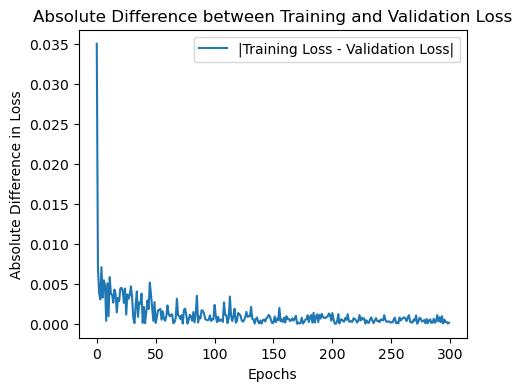

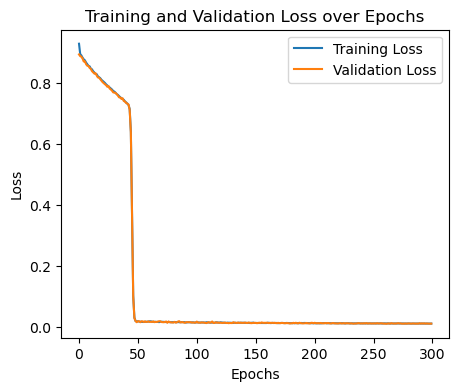

In [16]:
# Set model architecture
hidden1 = 235  # FC1, 235 units
hidden2 = 380  # FC2, 380 units
input_features = X_train.shape[-1]  # Input layer, size 8
output_features = y_train.shape[-1]  # Output, size 4

model = vFNN(
    in_features=input_features, 
    hidden_size1=hidden1, 
    hidden_size2=hidden2,
    out_features=output_features
)

epochs = 300
lr = 0.0005
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Start time
start = time.time()
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs, criterion, optimizer, kl_schedule="sigmoid_decay")
end = time.time()
training_time = end - start
print(f"Training took {training_time:.4f} seconds")

# Plot the training and validation losses
plot_losses(train_losses, val_losses, scale='linear', difference=True)
plot_losses(train_losses, val_losses, scale='linear')

In [18]:
def predict_with_uncertainty(model, test_loader, n_samples=100, scaler_y=None, device=torch.device('cpu')):
    model.eval()
    
    all_predictions = []
    true_values = []
    
    # Disable gradient computation for inference
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Store true values (used for comparison)
            true_values.append(targets.cpu().numpy())
            
            # Generate multiple predictions for each input
            predictions = []
            for _ in range(n_samples):
                outputs, _ = model(inputs)
                predictions.append(outputs.cpu().numpy())
                
            # Stack predictions across samples
            predictions = np.stack(predictions, axis=0)  # Shape: (n_samples, batch_size, num_outputs)
            all_predictions.append(predictions)

    # Concatenate predictions across all batches
    all_predictions = np.concatenate(all_predictions, axis=1)  # Shape: (n_samples, total_samples, num_outputs)
    true_values = np.concatenate(true_values, axis=0)  # Shape: (total_samples, num_outputs)

    # Apply inverse scaling if scaler_y is provided
    if scaler_y is not None:
        true_values = scaler_y.inverse_transform(true_values)
        all_predictions = np.array([scaler_y.inverse_transform(pred) for pred in all_predictions])

    return all_predictions, true_values

In [41]:
test_predictions, test_actuals = predict_with_uncertainty(model, test_loader, n_samples=100, scaler_y=Yscaler, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

print("Test Predictions shape:", test_predictions.shape)
print("Test Actuals shape:", test_actuals.shape)

Test Predictions shape: (100, 451, 4)
Test Actuals shape: (451, 4)


In [42]:
def calculate_mean_and_ci(predictions):
    # Mean of the predictions
    mean_predictions = np.mean(predictions, axis=0)  # Shape: (total_samples, num_outputs)

    # Std. deviation of predictions
    std_predictions = np.std(predictions, axis=0)    # Shape: (total_samples, num_outputs)

    ci = std_predictions
    return mean_predictions, ci

mean_predictions, ci = calculate_mean_and_ci(test_predictions)
print(f"Mean predictions shape: {mean_predictions.shape}")
print(f"Confidence interval shape: {ci.shape}")

Mean predictions shape: (451, 4)
Confidence interval shape: (451, 4)


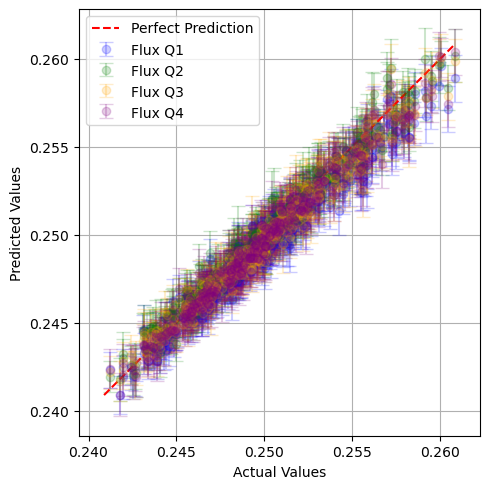

In [56]:
def plot_diagonal_validation_probabilistic_multiple(actuals, mean_predictions, uncertainty):
    colors = ['blue', 'green', 'orange', 'purple']  # Colors for each column
    plt.figure(figsize=(5, 5))

    # Plot each column with a different color
    for i in range(actuals.shape[1]):
        plt.errorbar(
            actuals[:, i], 
            mean_predictions[:, i], 
            yerr=uncertainty[:, i], 
            fmt='o', 
            alpha=0.2,
            capsize=5,
            label=f"Flux Q{i + 1}", 
            color=colors[i]
        )
    
    # Diagonal line (perfect predictions)
    min_val = min(np.min(actuals), np.min(mean_predictions))
    max_val = max(np.max(actuals), np.max(mean_predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")

    # Add labels, title, and legend
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")  # Equal scaling for x and y axes
    plt.tight_layout()
    plt.show()

plot_diagonal_validation_probabilistic_multiple(test_actuals, mean_predictions, ci)

In [57]:
# Calculate MAPE and RMSPE for each output
r2_scores = [r2_score(test_actuals[:, i], mean_predictions[:, i]) for i in range(output_features)]
mae_scores = [mean_absolute_error(test_actuals[:, i], mean_predictions[:, i]) for i in range(output_features)]
rmse_scores = [np.sqrt(mean_squared_error(test_actuals[:, i], mean_predictions[:, i])) for i in range(output_features)]
mape_scores = [np.mean(np.abs((test_actuals[:, i] - mean_predictions[:, i]) / test_actuals[:, i])) * 100 for i in range(output_features)]
rmspe_scores = [np.sqrt(np.mean(((test_actuals[:, i] - mean_predictions[:, i]) / (test_actuals[:, i])) ** 2)) * 100 for i in range(output_features)]

print(f"R2: {r2_scores}")
print(f"MAE: {mae_scores}")
print(f"RMSE: {rmse_scores}")
print(f"MAPE: {mape_scores}")
print(f"RMSPE: {rmspe_scores}")

R2: [0.9478591190095603, 0.973195833842508, 0.9653844361914043, 0.9659155774622249]
MAE: [0.0007107427, 0.00050783897, 0.0005789378, 0.000568208]
RMSE: [0.00092470745, 0.00066340965, 0.00075501925, 0.000749429]
MAPE: [0.2824711846187711, 0.20260759629309177, 0.23037721402943134, 0.22596498019993305]
RMSPE: [0.3653601510450244, 0.2639064332470298, 0.29888006392866373, 0.2961764810606837]


In [62]:
ci

array([[0.00123762, 0.000978  , 0.00113305, 0.00124518],
       [0.00146057, 0.00129305, 0.0009828 , 0.00132553],
       [0.0012214 , 0.00141738, 0.00130456, 0.00120384],
       ...,
       [0.00104191, 0.00121789, 0.00121737, 0.0015393 ],
       [0.00105032, 0.00102443, 0.00100265, 0.00111024],
       [0.00108897, 0.00138167, 0.00120682, 0.00093212]], dtype=float32)

In [63]:
def save_arrays_to_csv(array1: np.ndarray, array2: np.ndarray, array3: np.ndarray, filename: str):
    # Create a DataFrame from the three arrays
    df = pd.DataFrame({
        'True Flux Q1': array1[:, 0],
        'True Flux Q2': array1[:, 1],
        'True Flux Q3': array1[:, 2],
        'True Flux Q4': array1[:, 3],
        'Predicted Mean Flux Q1': array2[:, 0],
        'Predicted Mean Flux Q2': array2[:, 1],
        'Predicted Mean Flux Q3': array2[:, 2],
        'Predicted Mean Flux Q4': array2[:, 3],
        'Predicted Std. Dev. Flux Q1': array3[:, 0],
        'Predicted Std. Dev. Flux Q2': array3[:, 1],
        'Predicted Std. Dev. Flux Q3': array3[:, 2],
        'Predicted Std. Dev. Flux Q4': array3[:, 3],
    })

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)


save_arrays_to_csv(test_actuals, mean_predictions, ci, 'vFNNTest.csv')

## Predict on train data

Test Predictions shape: (100, 2102, 4)
Test Actuals shape: (2102, 4)
Mean predictions shape: (2102, 4)
Confidence interval shape: (2102, 4)


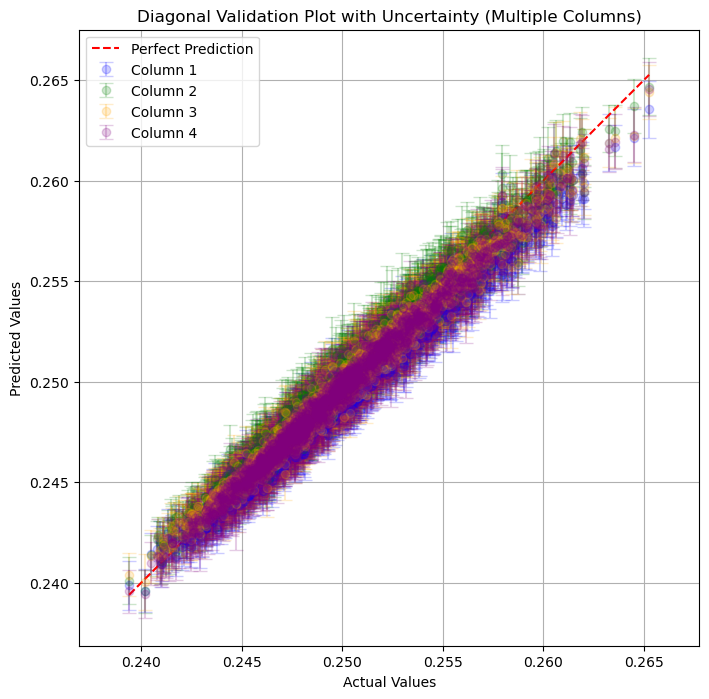

In [38]:
train_predictions, train_actuals = predict_with_uncertainty(model, train_loader, n_samples=100, scaler_y=Yscaler, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

print("Train Predictions shape:", train_predictions.shape)
print("Train Actuals shape:", train_actuals.shape)

mean_predictions, ci = calculate_mean_and_ci(train_predictions)
print(f"Mean predictions shape: {mean_predictions.shape}")
print(f"Confidence interval shape: {ci.shape}")

plot_diagonal_validation_probabilistic_multiple(train_actuals, mean_predictions, ci)

In [39]:
# Calculate MAPE and RMSPE for each output
r2_scores = [r2_score(train_actuals[:, i], mean_predictions[:, i]) for i in range(output_features)]
mae_scores = [mean_absolute_error(train_actuals[:, i], mean_predictions[:, i]) for i in range(output_features)]
rmse_scores = [np.sqrt(mean_squared_error(train_actuals[:, i], mean_predictions[:, i])) for i in range(output_features)]
mape_scores = [np.mean(np.abs((train_actuals[:, i] - mean_predictions[:, i]) / train_actuals[:, i])) * 100 for i in range(output_features)]
rmspe_scores = [np.sqrt(np.mean(((train_actuals[:, i] - mean_predictions[:, i]) / (train_actuals[:, i])) ** 2)) * 100 for i in range(output_features)]

print(f"R2: {r2_scores}")
print(f"MAE: {mae_scores}")
print(f"RMSE: {rmse_scores}")
print(f"MAPE: {mape_scores}")
print(f"RMSPE: {rmspe_scores}")

R2: [0.9595143352179015, 0.9783117041963658, 0.9758899821363775, 0.9714390986609157]
MAE: [0.00067645, 0.00050248485, 0.00051935867, 0.00056392956]
RMSE: [0.00086009444, 0.00062951806, 0.00066406204, 0.0007227629]
MAPE: [0.26861189398914576, 0.2007175935432315, 0.20676341373473406, 0.22426843643188477]
RMSPE: [0.33940263092517853, 0.25097522884607315, 0.26301403995603323, 0.28587719425559044]
